In [ ]:
#!pip install pytorch-pretrained-bert pytorch-nlp
#from pytorch_pretrained_bert import BertConfig
!pip install transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, BertConfig
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from google.colab import drive
import os
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import cohen_kappa_score
import itertools

drive.mount('/content/drive')
os.chdir('drive/MyDrive/MSC Machine Learning/COMP0087/Assignment2')

#https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03
# another article on how to use bert https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/
#paper on how to make BERT more computationally efficient. https://arxiv.org/pdf/1910.10781.pdf
#paper that uses this dataset https://cs224d.stanford.edu/reports/huyenn.pdf
#other paper https://www.aclweb.org/anthology/2020.bea-1.15.pdf

     |████████████████████████████████| 2.1MB 5.3MB/s 
     |████████████████████████████████| 901kB 15.0MB/s 
     |████████████████████████████████| 3.3MB 36.0MB/s 
Mounted at /content/drive


In [1]:
#helper functions
def import_data(essay_set):
  df_train = pd.read_excel('training_set_rel3.xlsx')
  df_dev = pd.read_excel('valid_set.xlsx')
  df_test = pd.read_csv('test_set.tsv', sep='\t', encoding='latin1')
  
  if essay_set is not None:
    df_train = df_train[df_train['essay_set']==essay_set]
    df_dev = df_dev[df_dev['essay_set']==essay_set]
    df_test = df_test[df_test['essay_set']==essay_set]
  
  return df_train, df_dev, df_test

def tokenize_sentences(sentences, max_len):
  sentences = ["[CLS] " + query + " [SEP]" for query in sentences]
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
  text_len = torch.LongTensor([len(txt) for txt in tokenized_texts])
  input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=max_len, dtype="long", truncating="post", padding="post")
  input_ids[input_ids[:,-1]!=0,-1] = tokenizer.sep_token_id  #if a sentence has been cut short, make sure last token is SEP
  input_ids = torch.LongTensor(input_ids)

  #attention masks define which tokens the model pays attention to
  attention_masks = np.ones(input_ids.shape)
  attention_masks = torch.LongTensor(attention_masks)
  attention_masks[input_ids==0] = 0

  return input_ids, attention_masks, text_len

def evaluate_dev_data():
  yhat_dev_ts = torch.LongTensor([]).to(device)
  y_dev_ts = torch.LongTensor([]).to(device)
  for x_batch, mask_batch, y_batch in dev_loader:
    x_batch = x_batch.to(device)
    mask_batch = mask_batch.to(device)
    y_batch = y_batch.to(device)     
    if reg=='class':
      y_batch = y_batch.type(torch.LongTensor).to(device)                 
    #update backgrients and perform backprop        
    yhat_dev = model.forward(x_batch, mask_batch)
    yhat_dev_ts = torch.cat([yhat_dev_ts, yhat_dev])
    y_dev_ts = torch.cat([y_dev_ts, y_batch])

  return yhat_dev_ts, y_dev_ts

def compute_kappa(yhat_ts, y_ts):
  yhat_np = np.around(yhat_ts.cpu().detach().numpy().squeeze(),0)
  y_np = np.around(y_ts.cpu().detach().numpy().squeeze(),0)
  if yhat_np.ndim==1:
    my_kappa = cohen_kappa_score(yhat_np, y_np, weights='quadratic')  
  else:
    n_elements = yhat_np.shape[1]
    my_kappa = np.zeros(n_elements)
    for i in range(n_elements):
      my_kappa[i] = cohen_kappa_score(yhat_np[:,i], y_np[:,i], weights='quadratic')

  return my_kappa

def evaluate_epoch(criteria):
  """save the model if it's the best one and define whether it has converged"""
  if reg=='multi':
    overall_kappa = [kappa[-1] for kappa in kappa_dev]
  else:
    overall_kappa = kappa_dev

  if overall_kappa[-1]==np.max(overall_kappa):
    torch.save(model, model_label)

  if criteria=='kappa':
    if len(overall_kappa) - np.argmax(overall_kappa) == tolerance+1:
      converged = True     
    else:
      converged = False 
  elif criteria=='loss':
    if len(loss_ts_dev) - np.argmin(loss_ts_dev) == tolerance+1:
      converged = True     
    else:
      converged = False 

  end = time.time()
  print('Epoch {:}: Training Loss is {:.4f}, training kappa {:}. Dev loss is {:.3f}, dev kappa is {:},  time is {:.0f}'.format(
      e, loss_ts[-1], kappa_train[-1], loss_ts_dev[-1], kappa_dev[-1], end-start))
  
  return converged

def finalize_model():
    """prints the final model performance and saves the key stats"""
    big_end = time.time()
    print('{:}: Training Loss is {:.4f}, dev loss is {:.3f}, dev kappa is {:}, time is {:.0f}'.format(
        model_label, loss_ts[-(tolerance+1)], loss_ts_dev[-(tolerance+1)], kappa_dev[-(tolerance+1)], big_end-big_start)) 
    print('---------------------')   
    torch.cuda.empty_cache()

    #save results
    np.save(model_label+'_loss.npy',loss_ts)    
    np.save(model_label+'_loss_dev.npy',loss_ts_dev) 
    np.save(model_label+'_kappa_train.npy',kappa_train) 
    np.save(model_label+'_kappa_dev.npy',kappa_dev) 

def optimize_model(x_batch, mask_batch, y_batch, yhat_ts, y_train_ts):
  """Performs gradient descent on the relevant model"""
  x_batch = x_batch.to(device)
  mask_batch = mask_batch.to(device)
  y_batch = y_batch.to(device)
  if reg=='class':
    y_batch = y_batch.type(torch.LongTensor).to(device)

  #update backgrients and perform backprop        
  optimizer.zero_grad()
  yhat = model.forward(x_batch, mask_batch)
  yhat_ts = torch.cat([yhat_ts, yhat])
  y_train_ts = torch.cat([y_train_ts, y_batch])
  loss = criterion(yhat.squeeze(), y_batch)
  loss.backward()
  nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.0)
  optimizer.step()

  return model, yhat_ts, y_train_ts

In [ ]:
#load data
df_train, df_dev, df_test = import_data(essay_set=7)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
max_len = 512
input_ids, attention_masks, text_len = tokenize_sentences(df_train['essay'].tolist(), max_len)
# input_ids_dev, attention_masks_dev, text_len_dev = tokenize_sentences(df_dev['essay'].tolist(), max_len)
# input_ids_test, attention_masks_test, text_len_test = tokenize_sentences(df_test['essay'].tolist(), max_len)

#get train, dev, test splits
y = torch.Tensor(df_train['domain1_score'].values)
y_multi = df_train[['rater1_trait1','rater1_trait2','rater1_trait3','rater1_trait4']].values + df_train[['rater2_trait1','rater2_trait2','rater2_trait3','rater2_trait4']].values
y_multi = np.concatenate([y_multi, df_train['domain1_score'].values.reshape(-1,1)], axis=1)
y_multi = torch.Tensor(y_multi)
input_ids_train, input_ids_test, attention_masks_train, attention_masks_test, y_train, y_test, y_multi_train, y_multi_test = \
    train_test_split(input_ids,attention_masks, y, y_multi, test_size=0.2, random_state=42)
input_ids_train, input_ids_dev, attention_masks_train, attention_masks_dev, y_train, y_dev, y_multi_train, y_multi_dev = \
    train_test_split(input_ids_train,attention_masks_train, y_train, y_multi_train, test_size=0.2, random_state=42)

#encode question prompt
prompt ='''Write about patience. Being patient means that you are understanding and tolerant. A patient person experience difficulties without complaining. 
  Do only one of the following: write a story about a time when you were patient OR write a story about a 
  time when someone you know was patient OR write a story in your own way about patience.'''
tokenized_prompt, attention_prompt, len_prompt = tokenize_sentences([prompt], max_len)
tokenized_prompt = tokenized_prompt.to(device)
attention_prompt = attention_prompt.to(device)
#tokenized_prompt = tokenized_prompt[attention_prompt==1]
# bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
# prompt_encoding = bert_model(tokenized_prompt.cpu(), attention_prompt.cpu())['pooler_output'].detach().to(device)

The proportion of essays with length below 512 is 0.9751434326171875
The proportion of essays with length below tensor([447]) is 0.9464626908302307


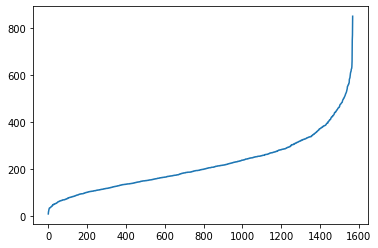

In [ ]:
#plot text len
import matplotlib.pyplot as plt
text_len_sort = text_len.cpu().numpy().copy()
text_len_sort.sort()
plt.plot(text_len_sort)

pct_lower = torch.sum(text_len<=512)/text_len.shape[0]
pct_lower2 = torch.sum(text_len<=512-len_prompt)/text_len.shape[0]
print('The proportion of essays with length below 512 is {0}'.format(pct_lower))
print('The proportion of essays with length below {0} is {1}'.format(512-len_prompt, pct_lower2))

In [ ]:
#old models, not currently being used
class EssayModel2(nn.Module):
  """Model for essay grading using BERT embeddings"""
  def __init__(self, hidden_dim, encode_question):
    super().__init__()
    self.bert_dim = 768
    self.encode_question = encode_question

    #network layers
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME).to(device)    
    for param in self.bert.parameters(): #keep bert parameters frozen
      param.requires_grad = False
    self.lstm = nn.LSTM(self.bert_dim, hidden_dim, batch_first=True)   
    self.l2 = nn.Linear(in_features=hidden_dim, out_features=1)     

  def forward(self, input_ids, attention_masks, tokenized_prompt):
    x = self.bert(input_ids, attention_masks)['last_hidden_state']
    output, (x, c_n) = self.lstm(x)
    x = self.l2(x.squeeze())
    return x

class EssayModel_LSTM(nn.Module):
  """Model for essay grading using BERT embeddings"""
  def __init__(self, seq_len, overlap, hidden_dim):
    super().__init__()
    self.seq_len = seq_len
    self.overlap = overlap
    self.step_size = seq_len - overlap
    self.bert_dim = 768
    self.hidden_dim = hidden_dim

    #network layers
    self.lstm = nn.LSTM(self.bert_dim, hidden_dim, batch_first=True)
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME).to(device)
    #keep bert parameters frozen
    for param in self.bert.parameters():
      param.requires_grad = False

  def forward(self, input_ids, attention_masks, tokenized_prompt):
    #split sequence up and pass each one through BERT
    batch_size, max_len = input_ids.shape
    n_models = max_len//(self.step_size) + 1
    lstm_input = torch.zeros((batch_size, n_models, self.bert_dim)).to(device)
    for i in range(n_models):  #loop over BERT passes
      my_start = i*self.step_size
      my_end = np.min([my_start+self.seq_len, max_len])
      y = self.bert(input_ids[:, my_start:my_end], attention_masks[:, my_start:my_end])
      lstm_input[:,i,:] = y['pooler_output']

    #pass data through lstm
    output, (h_n, c_n) = self.lstm(lstm_input)
    return output, h_n.squeeze()

    #code no longer used to freeze bert
    # for param in self.bert.parameters(): #keep bert parameters frozen
    #   param.requires_grad = False
    #freeze the embedings and first 10 layers of the encoder
    # modules = [self.bert.embeddings, *self.bert.encoder.layer[:10]] 
    # for module in modules:
    #     for param in module.parameters():
    #         param.requires_grad = False

In [ ]:
class EssayModel(nn.Module):
  """Model for essay grading using BERT embeddings"""
  def __init__(self, hidden_dim, encode_question, regression, dropout, 
               tokenized_prompt, attention_prompt, output_shape=1):
    super().__init__()
    self.bert_dim = 768
    self.encode_question = encode_question    
    self.regression = regression
    self.output_shape = output_shape
    self.dropout = dropout
    self.tokenized_prompt = tokenized_prompt
    self.attention_prompt = attention_prompt

    if self.encode_question:
      self.hidden_dim = hidden_dim
    else:
      self.hidden_dim = self.bert_dim`

    #network layers
    configuration = BertConfig()
    configuration.attention_probs_dropout_prob = dropout
    configuration.hidden_dropout_prob = dropout
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, config=configuration).to(device)    
    #print(self.bert)
    
    if self.encode_question:
      self.l1 = nn.Linear(in_features=2*self.bert_dim, out_features=self.hidden_dim)
      self.BatchNorm = nn.BatchNorm1d(self.hidden_dim)

    self.l2 = nn.Linear(in_features=self.hidden_dim, out_features=self.output_shape)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_masks):
    x = self.bert(input_ids, attention_masks)['pooler_output']
    if self.encode_question:
      #tokenized_prompt = tokenized_prompt.expand(x.shape[0], -1)
      prompt_encoding = self.bert(self.tokenized_prompt, self.attention_prompt)['pooler_output']
      prompt_encoding = prompt_encoding.expand(x.shape[0], -1)
      x = torch.cat([x, prompt_encoding], dim=1)
      x = F.relu(self.BatchNorm(self.l1(x)))
    
    #if a classification task, apply softmax activation
    if self.regression=='reg':
      x = self.l2(x)
    elif self.regression=='multi':
      x = self.l2(x)
      x = torch.cat([x,x.sum(1).view(-1,1)], axis=1)  #append total grade to the end
    elif self.regression=='class':
      x = self.softmax(self.l2(x))
    return x

In [ ]:
#training loop
perform_training = 0
if perform_training==1:  
  tolerance = 4

  #beginning of training
  alpha_range=[2e-5, 1e-5]
  alpha_range=[2e-5]
  encode_q_list = [False, True]
  reg_list = ['class','multi','reg']
  dropout_list = [0.1,0.2]
  param_range = list(itertools.product(encode_q_list, alpha_range, reg_list, dropout_list))
  #loop over parameter combinations
  for encode_question, lr, reg, dropout in param_range:
    torch.manual_seed(42)
    big_start = time.time()
    model_label = 'q7_encode{0}_alpha{1}_reg{2}_dropout{3}'.format(encode_question, lr, reg, dropout)
    print('Training {0}'.format(model_label))
    if reg=='reg':
      criterion = nn.MSELoss()
      output_shape = 1
    elif reg=='class':
      criterion = nn.CrossEntropyLoss()
      output_shape = int(df_train['domain1_score'].max()) + 1
    elif reg=='multi':
      criterion = nn.MSELoss()
      output_shape = y_multi.shape[1] - 1
    
    #define data to be used
    if reg=='multi':
      train_data = torch.utils.data.TensorDataset(input_ids_train, attention_masks_train, y_multi_train)
      dev_data = torch.utils.data.TensorDataset(input_ids_dev, attention_masks_dev, y_multi_dev)
    else:      
      train_data = torch.utils.data.TensorDataset(input_ids_train, attention_masks_train, y_train)
      dev_data = torch.utils.data.TensorDataset(input_ids_dev, attention_masks_dev, y_dev)
    train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=16, shuffle=True, num_workers=4)
    dev_loader = torch.utils.data.DataLoader(dataset=dev_data, batch_size=16, shuffle=False, num_workers=4)

    #define model
    model = EssayModel(hidden_dim=512, encode_question=encode_question, 
                       regression=reg, output_shape=output_shape, 
                       dropout=dropout, tokenized_prompt=tokenized_prompt,
                       attention_prompt=attention_prompt).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    #lists to store results
    loss_ts = []
    loss_ts_dev = []
    kappa_ts = []
    kappa_train = []
    kappa_dev = []
    e = 0

    #loop over epochs
    converged = False
    while converged==False:
      start = time.time()
      model.train()
      yhat_ts = torch.LongTensor([]).to(device)
      y_train_ts = torch.LongTensor([]).to(device)
      #loop over batches and train model
      for x_batch, mask_batch, y_batch in train_loader:
        model, yhat_ts, y_train_ts = optimize_model(x_batch, mask_batch, y_batch, yhat_ts, y_train_ts)
      else:  #at the end of an epoch, update total loss and kappa
        # print('after a run of GD')
        # print(model.bert)
        model.eval()
        with torch.no_grad():
          loss_ts.append(criterion(yhat_ts.squeeze(), y_train_ts))  #append loss list
          if reg=='class':
            yhat_ts = yhat_ts.argmax(1)
          my_kappa = compute_kappa(yhat_ts, y_train_ts)
          kappa_train.append(my_kappa)  #append kappa list

          #evaluate dev data
          del yhat_ts, y_train_ts, x_batch, mask_batch, y_batch 
          yhat_dev_ts, y_dev_ts = evaluate_dev_data()

        loss_ts_dev.append(criterion(yhat_dev_ts.squeeze(), y_dev_ts))  #append loss list
        if reg=='class':
          yhat_dev_ts = yhat_dev_ts.argmax(1)  
        my_kappa = compute_kappa(yhat_dev_ts,y_dev_ts)      
        kappa_dev.append(my_kappa)  #append kappa list

      e+=1      
      converged = evaluate_epoch(criteria='kappa') #if it's the best model so far, save it

    del model  #helps save memory
    finalize_model()


In [ ]:
#display results
def return_overall(kappa):
  if kappa.ndim==0:
    result = kappa
  else:
    result = kappa[-1]
  return result

#display results
tolerance = 4
alpha_range=[2e-5]
encode_q_list = [False, True]
reg_list = ['class','multi','reg']
dropout_list = [0.1, 0.2]
param_range = list(itertools.product(encode_q_list, alpha_range, reg_list, dropout_list))
kappa_train_dict={}
kappa_dev_dict={}
model_labels=[]
for encode_question, lr, reg, dropout in param_range:
  model_label = 'q7_encode{0}_alpha{1}_reg{2}_dropout{3}'.format(encode_question, lr, reg, dropout)
  model_labels.append(model_label)
  kappa_train_dict[model_label] = np.load(model_label+'_kappa_train.npy')
  kappa_dev_dict[model_label] = np.load(model_label+'_kappa_dev.npy')
  if reg=='multi':
    kappa_train_dict[model_label] = [return_overall(entry) for entry in kappa_train_dict[model_label]]
    kappa_dev_dict[model_label] = [return_overall(entry) for entry in kappa_dev_dict[model_label]]

false_train_list = [kappa_train_dict[label][-(tolerance+1)] for label in model_labels if 'encodeFalse' in label]
true_train_list = [kappa_train_dict[label][-(tolerance+1)] for label in model_labels if 'encodeTrue' in label]
false_dev_list = [kappa_dev_dict[label][-(tolerance+1)] for label in model_labels if 'encodeFalse' in label]
true_dev_list = [kappa_dev_dict[label][-(tolerance+1)] for label in model_labels if 'encodeTrue' in label]
false_labels = [label[label.find('reg'):] for label in model_labels if 'encodeFalse' in label]

#create dataframe
# df = pd.DataFrame({'Label':false_labels,
#                    'Train_EncodeFalse':false_train_list, 
#                    'Train_EncodeTrue':true_train_list,
#                    'Dev_EncodeFalse':false_dev_list,
#                    'Dev_EncodeTrue':true_dev_list})
print('Dev set weighted kappa scores:')
df = pd.DataFrame({'Label':false_labels,
                   'Kappa Score (Train)':false_train_list,                    
                   'Kappa Score (Dev)':false_dev_list})
df

Dev set weighted kappa scores:


,Label,Kappa Score (Train),Kappa Score (Dev)
0,regclass_dropout0.1,0.731499,0.655914
1,regclass_dropout0.2,0.603674,0.617021
2,regmulti_dropout0.1,0.910254,0.833333
3,regmulti_dropout0.2,0.931065,0.762351
4,regreg_dropout0.1,0.957424,0.792432
5,regreg_dropout0.2,0.905750,0.761601


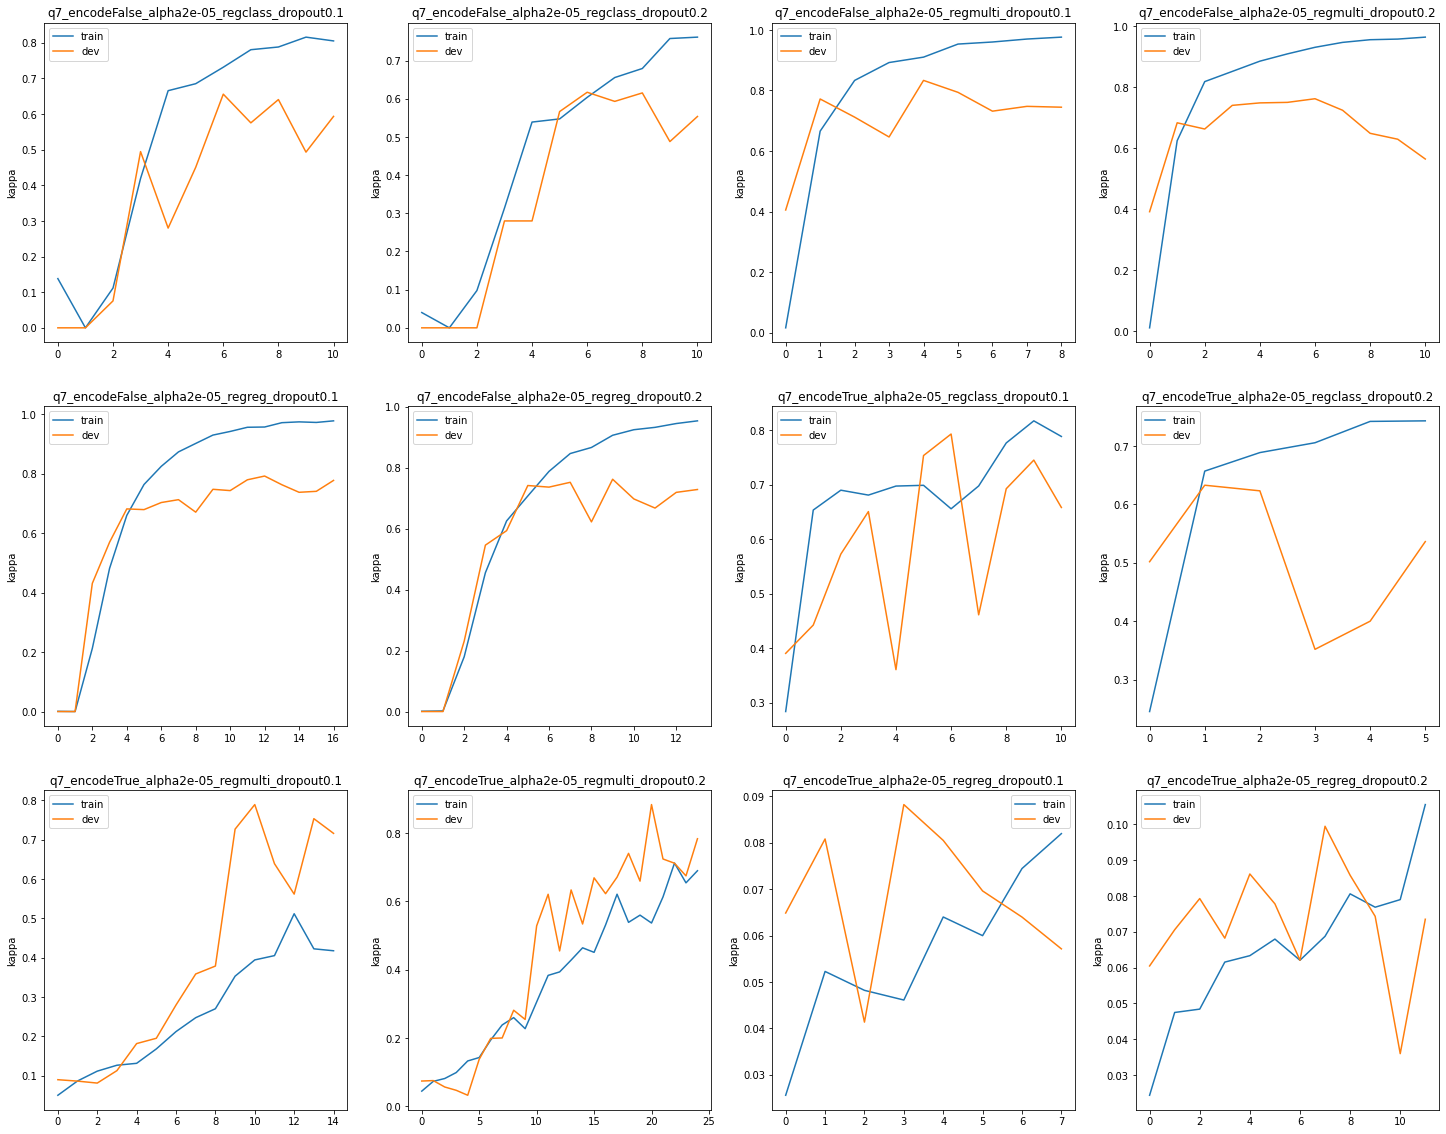

In [ ]:
#plot results
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(25,20))
for i in range(len(model_labels)):
  my_label = model_labels[i]
  row = i//4
  col = i-row*4
  ax[row,col].plot(kappa_train_dict[my_label], label='train')
  ax[row,col].plot(kappa_dev_dict[my_label], label='dev')
  ax[row,col].set(title=my_label, ylabel='kappa')
  ax[row,col].legend()
plt.show()

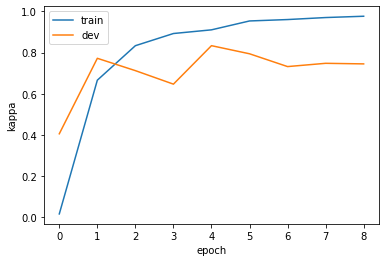

In [ ]:
#plot just the learning curve for multilabel
my_label='q7_encodeFalse_alpha2e-05_regmulti_dropout0.1'
fig, ax = plt.subplots()

ax.plot(kappa_train_dict[my_label], label='train')
ax.plot(kappa_dev_dict[my_label], label='dev')
ax.set(ylabel='kappa', xlabel='epoch')
ax.legend()
plt.savefig('multilabel_curve.png')
plt.show()

In [ ]:
#get results for multi class
train_kappa_list=[]
dev_kappa_list=[]
model_labels=[]
table_labels=[]
for encode_question, lr, reg, dropout in param_range:
  if reg!='multi':
    continue
  model_label = 'q7_encode{0}_alpha{1}_reg{2}_dropout{3}'.format(encode_question, lr, reg, dropout)
  table_label = 'reg{0}_dropout{1}'.format(reg, dropout)
  model_labels.append(model_label)
  table_labels.append(table_label)
  train_kappa = np.load(model_label+'_kappa_train.npy')
  dev_kappa = np.load(model_label+'_kappa_dev.npy')
  train_kappa_list.append(train_kappa[-(tolerance+1)])
  dev_kappa_list.append(dev_kappa[-(tolerance+1)])

df_multi = pd.DataFrame(dev_kappa_list, columns=['trait1','trait2','trait3','trait4','overall'], index=table_labels)
df_multi

,trait1,trait2,trait3,trait4,overall
regmulti_dropout0.1,0.729577,0.546559,0.555556,0.333333,0.833333
regmulti_dropout0.2,0.802691,0.708207,0.527559,0.433333,0.762351
regmulti_dropout0.1,0.684848,0.510791,0.588785,0.553073,0.789116
regmulti_dropout0.2,0.777778,0.648352,0.769231,0.666667,0.883659


In [ ]:
#LSTM Training
# useful libraries
import numpy as np
import pandas as pd
import nltk 
from nltk.corpus import stopwords                   
from nltk.stem import PorterStemmer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer          
from gensim.models import Word2Vec
import re
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
import gensim

In [ ]:
# # import files
# from google.colab import files

# uploaded = files.upload()
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('drive/MyDrive/COMP0087/')

In [ ]:
# Download w2v
%%shell
import wget

wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"


In [ ]:
model_g = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True) 
# import file 
df = pd.read_csv("training_set_rel3.tsv", sep='\t', encoding='ISO-8859-1')
# only keep info for essays within essay set 7
df = df[df.essay_set == 7]

In [ ]:
# create a list of tokens using every word in essay
# For testing now, to check if the baseline is working
def essay_to_wordlist(essay_v, remove_stopwords):
    """Remove the tagged labels and word tokenize the sentence."""
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v)
    #words = essay_v.lower().split()
    words = essay_v.split()
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    return words

In [ ]:
wv = model_g.wv
# Just to test, averaged all the word embeddings in the whole paragraph into a single embedding vector.
# function to change list of tokens to word embedding using word2vec
# not being used
def avgW2vRepresentation( passage ):
    counterWordsVocab = 0
    w2vRepresentation = np.zeros(300)
    for words in passage:
        if words in wv:
            counterWordsVocab +=1
            w2vRepresentation += wv[words]

    if(counterWordsVocab != 0):
        w2vRepresentation /= counterWordsVocab

    return w2vRepresentation

# is being used
def embed_paragraph(passage):
  embedded_vect = []
  for words in passage:
    if words in wv:
      embedded_vect.append(wv[words])
    
  return np.array(embedded_vect)

In [ ]:
# Pre-processing
tokenized_no_stopwords = []; finalized_essay = []
essays = np.array(df['essay'])
essay_1 = essays[0]
for essay in essays:
  # tokanise essays but do not remove stopwords
  tokenized_no_stopwords.append(essay_to_wordlist(essay, False))

max_len = 0
for tokenized_essay in tokenized_no_stopwords:
  em_par = embed_paragraph(tokenized_essay)
  par_len = em_par.shape[0]
  if max_len < par_len:
    max_len = par_len
  finalized_essay.append(em_par)

# Pad anyhow, and ignore with padded
padded_embed = []; lengths = []
for embedding in finalized_essay:
  essay_len = embedding.shape[0]
  template = np.zeros((max_len, 300))
  template[:essay_len, :] = embedding
  padded_embed.append(template)
  lengths.append(essay_len)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size = 300, hidden_layer_size_1 = 300, hidden_layer_size_2 = 64, output_size = 16, loss_function = None, lr = 0.001, dropout_amount = 0.4):
        super().__init__()
        self.hidden_layer_size_1 = hidden_layer_size_1
        self.hidden_layer_size_2 = hidden_layer_size_2
        self.lstm = nn.LSTM(input_size, hidden_layer_size_1, batch_first = True, dropout = dropout_amount) 
        self.lstm_2 = nn.LSTM(hidden_layer_size_1, hidden_layer_size_2, batch_first = True, dropout = dropout_amount)        
        self.linear = nn.Linear(hidden_layer_size_2, output_size)

        self.loss = loss_function if loss_function is not None else nn.CrossEntropyLoss()
        self.lr = lr

        return None
        

    def forward(self, input_seq):
        # print(f"Input shape {input_seq.shape}")
        # lstm_out, self.hidden_cell = self.lstm(input_seq.view(1, input_seq.shape[0], input_seq.shape[1]))
        lstm_out, self.hidden_cell = self.lstm(input_seq)
        lstm_out, self.hidden_cell = self.lstm_2(lstm_out)
        result_unpacked, lengths_unpacked = pad_packed_sequence(lstm_out, batch_first = True)
        linear_input = result_unpacked[np.arange(result_unpacked.shape[0]), lengths_unpacked - 1, :]
        # predictions = self.linear(lstm_out.view(input_seq.shape[0], -1))
        predictions = self.linear(linear_input)
        #predictions = F.relu(predictions)
        return predictions

def pack_data(data, lengths):
  input_tens = torch.tensor(data, dtype = torch.float)
  packed_seq = pack_padded_sequence(input_tens, lengths, batch_first = True, enforce_sorted = False)
  return packed_seq

def train_model(models, data, labels, epoch, optim = None):
  """
  models = list of models, length m
  data = N x D
  labels = N x m
  """
  input = data.to(device)
  for j in range(len(models)):
    print(f"Model {j+1}")
    model = models[j].to(device); label = labels[:, j]; optimizer = optim if optim is not None else torch.optim.Adam(model.parameters(), lr = model.lr)
    for i in range(epoch):
      print(f"Epoch {i + 1}")
      optimizer.zero_grad()
      y_pred = model(input)
      single_loss = model.loss(y_pred, torch.tensor(label, dtype = torch.long).to(device))
      print(f"Loss: {single_loss}")
      single_loss.backward()
      optimizer.step()

def evaluate_model(models, data, labels, score = 'kappa'):
  input = data.to(device); scores = []
  for model_idx in range(len(models)):
    model = models[model_idx]
    preds = model(input).cpu().detach().numpy()
    preds = np.argmax(preds, axis = 1).reshape(-1)
    label = labels[:, model_idx].reshape(-1)
    if score is 'kappa':
      pred_score = cohen_kappa_score(preds, label, weights = 'quadratic')
    elif score is 'acc':
      pred_score = np.mean(preds == label)
    
    scores.append(pred_score)

  return scores


In [ ]:
# to split the data into 80% train and 20% test set
all_data = df[[df.columns[2], df.columns[6],df.columns[10], df.columns[11], df.columns[12],df.columns[13],\
               df.columns[16],df.columns[17],df.columns[18],df.columns[19] ]]

train_data_all, test_data = train_test_split(all_data, test_size=0.2, train_size=0.8, random_state=42, shuffle=True, stratify=None)
train_data, dev_data = train_test_split(train_data_all, test_size=0.2, train_size=0.8, random_state=42, shuffle=True, stratify=None)

In [ ]:
# prepare training data
train_data_array = np.array(train_data)
N,d = train_data_array.shape
y_train = np.zeros((N, 5))
#x_train[:,0] = train_data_array[:,0]
y_train[:,0] = train_data_array[:,1]
y_train[:,1] = train_data_array[:,2] + train_data_array[:,6]
y_train[:,2] = train_data_array[:,3] + train_data_array[:,7]
y_train[:,3] = train_data_array[:,4] + train_data_array[:,8]
y_train[:,4] = train_data_array[:,5] + train_data_array[:,9]

In [ ]:
# prepare test data
test_data_array = np.array(test_data)
N_t,d_t = test_data_array.shape
y_test = np.zeros((N_t, 5))
#x_train[:,0] = train_data_array[:,0]
y_test[:,0] = test_data_array[:,1]
y_test[:,1] = test_data_array[:,2] + test_data_array[:,6]
y_test[:,2] = test_data_array[:,3] + test_data_array[:,7]
y_test[:,3] = test_data_array[:,4] + test_data_array[:,8]
y_test[:,4] = test_data_array[:,5] + test_data_array[:,9]

In [ ]:
# prepare train data

# Pre-processing
tokenized_no_stopwords = []; finalized_essay = []
essays = np.array(train_data['essay'])
essay_1 = essays[0]
for essay in essays:
  tokenized_no_stopwords.append(essay_to_wordlist(essay, True))

max_len = 0
for tokenized_essay in tokenized_no_stopwords:
  em_par = embed_paragraph(tokenized_essay)
  par_len = em_par.shape[0]
  if max_len < par_len:
    max_len = par_len
  finalized_essay.append(em_par)

# Pad anyhow, and ignore with padded
padded_embed = []; lengths = []
for embedding in finalized_essay:
  essay_len = embedding.shape[0]
  template = np.zeros((max_len, 300))
  template[:essay_len, :] = embedding
  padded_embed.append(template)
  lengths.append(essay_len)

scores_train = np.array(train_data.iloc[:,1:])
data = pack_data(padded_embed, lengths)

In [ ]:
# prepare input essays from x test to evaluate the model

# Pre-processing
tokenized_no_stopwords = []; finalized_essay = []
essays = np.array(test_data['essay'])
essay_1 = essays[0]
for essay in essays:
  tokenized_no_stopwords.append(essay_to_wordlist(essay, True))

max_len = 0
for tokenized_essay in tokenized_no_stopwords:
  em_par = embed_paragraph(tokenized_essay)
  par_len = em_par.shape[0]
  if max_len < par_len:
    max_len = par_len
  finalized_essay.append(em_par)

# Pad anyhow, and ignore with padded
padded_embed = []; lengths = []
for embedding in finalized_essay:
  essay_len = embedding.shape[0]
  template = np.zeros((max_len, 300))
  template[:essay_len, :] = embedding
  padded_embed.append(template)
  lengths.append(essay_len)

In [ ]:
# prepare labels and pack data for evaluation
test_scores = np.array(test_data.iloc[:,1:])
test_data = pack_data(padded_embed, lengths)

In [ ]:
# prepare input essays from x dev to evaluate the model

# Pre-processing
tokenized_no_stopwords = []; finalized_essay = []
essays = np.array(dev_data['essay'])
essay_1 = essays[0]
for essay in essays:
  tokenized_no_stopwords.append(essay_to_wordlist(essay, True))

max_len = 0
for tokenized_essay in tokenized_no_stopwords:
  em_par = embed_paragraph(tokenized_essay)
  par_len = em_par.shape[0]
  if max_len < par_len:
    max_len = par_len
  finalized_essay.append(em_par)

# Pad anyhow, and ignore with padded
padded_embed = []; lengths = []
for embedding in finalized_essay:
  essay_len = embedding.shape[0]
  template = np.zeros((max_len, 300))
  template[:essay_len, :] = embedding
  padded_embed.append(template)
  lengths.append(essay_len)

# prepare labels and pack data for evaluation
dev_scores = np.array(dev_data.iloc[:,1:])
dev_data = pack_data(padded_embed, lengths)

In [ ]:
# run final model
models = [LSTM(lr = 0.001, hidden_layer_size_1 = 200, hidden_layer_size_2 = 100, dropout_amount = 0.6, output_size = int(max(y_train[:,i]) +1)) for i in range(y_train.shape[1])]
train_model(models, data, y_train, 500)

In [ ]:
saving all the models
for index,actualModel in enumerate(models):
  modelLabel = "lstmFinalModel"+str(index)
  torch.save(actualModel, modelLabel)
  print(modelLabel)
 